Load, Clean and Analyse the New York Airbnb Dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Load and Clean the data

Read the CSV file. 

The parse_dates and dtype attributes were assigned after checking the columns and dtypes.

In [2]:
df = pd.read_csv('Airbnb_Open_Data.csv', parse_dates=['last review'], dtype={'license':object})

Change the column names for ease of use with sqlite. 

Corrected the 'neighbourhood_group' name for Brooklyn after review later in the code. 

In [3]:
df.columns = df.columns.str.replace(' ','_').str.lower()

df.neighbourhood_group = df.neighbourhood_group.replace('brookln', 'Brooklyn')

Convert the columns including prices from Objects to Floats, whilst omitting all chars apart from digits and decimals. 

Also take into account commas.

In [4]:
Col = ['price', 'service_fee']

for i in Col:
    df[i] = pd.to_numeric(df[i].replace(r'[^\d.]', '', regex=True), errors='coerce')


Having duplicates in the following columns meets my criteria for being considered a duplicate. 
The column names were amended following analysis later in the project. 

In [5]:
df = df.drop_duplicates(subset=['name', 'host_name', 'last_review', 'lat', 'long'], keep='first')

Drop na values from the below columns. 

The below columns will be used in my analysis. The other columns were left as is so as to not reduce the amount of information available. 

In [6]:
check_na = ['price', 'neighbourhood', 'neighbourhood_group', 'number_of_reviews', 'host_name', 'review_rate_number', 'reviews_per_month', 'availability_365']
df = df.dropna(subset=check_na)

Reset the index due to dropping duplicates and rows with na values. 

In [7]:
df.reset_index(drop=True, inplace=True)

Review Outliers

In [8]:
check_outliers = ['price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
print(df.describe()[check_outliers])


              price   service_fee  minimum_nights  number_of_reviews  \
count  56816.000000  56625.000000    56540.000000       56816.000000   
mean     625.516897    125.058455        8.193792          32.996920   
min       50.000000     10.000000     -365.000000           1.000000   
25%      339.000000     68.000000        2.000000           3.000000   
50%      625.000000    125.000000        3.000000          11.000000   
75%      913.000000    183.000000        5.000000          38.000000   
max     1200.000000    240.000000     5645.000000        1024.000000   
std      331.931093     66.391192       32.364724          54.816605   

       reviews_per_month  calculated_host_listings_count  
count       56816.000000                    56727.000000  
mean            1.398513                        8.011212  
min             0.010000                        1.000000  
25%             0.240000                        1.000000  
50%             0.790000                        1.000000

The below notes are based on the above information. 

minimum_nights - The mean is ~8, whilst the min is -365 and the max is 5645.

number_of_reviews - The mean is ~32, whilst the max is 1024.

reviews_per_month - The mean is ~1.4, whilst the max is 90 (This is impossible)

calculated_host_listings_count - The mean is ~8, whilst the max is 332


Due to this, I've amended the check_outliers list as below.

In [9]:
check_outliers = ['price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']

Review outliers based on Standard Deviation

Let colstd1 and colstd2 equal the mean + or - the standard deviation. 

Create a function to check if the row is outside of the range between colstd1 and colstd2. 

Return False if outside the range, else True.

Update: Added a conditional to get rid of values of 0 and less for the 'minimum_nights' column as wasn't picked up in the mean + or - std. 

This code wasn't applied since ~65% of the dataset would be dropped. 

In [10]:
colstd1 = []
colstd2 = []
for i in check_outliers:
    colstd1.append(df[i].mean() + df[i].std())
    colstd2.append(df[i].mean() - df[i].std())

def check(x):
    for a in check_outliers:
        if x[a] > colstd1[check_outliers.index(a)] or x[a] < colstd2[check_outliers.index(a)]:
            return False
        
        elif x['minimum_nights'] <= 0:
            return False
            
        elif x['availability_365'] <= 0:
            return False
        
        else:
            continue
    
    return True

print(len(df))

56816


Review outliers based on Interquartile Range
Adapted from the above. 

This code wasn't applied since ~50% of the dataset would be dropped. 

In [11]:
IQR1 = []
IQR2 = []
for i in check_outliers:
    Q3 = df[i].quantile(0.75)
    Q1 = df[i].quantile(0.25)
    IQR = (Q3 - Q1) * 1.5
    IQR1.append(Q1 - IQR)
    IQR2.append(Q3 + IQR)

def check2(x):
    for a in check_outliers:
        if x[a] > IQR2[check_outliers.index(a)] or x[a] < IQR1[check_outliers.index(a)]:
            return False
        
        elif x['minimum_nights'] <= 0:
            return False
        
        elif x['availability_365'] <= 0:
            return False
        
        else:
            continue
    
    return True
    
print(len(df))

56816


Review outliers based on the 1st and 99th percentile 
Adapted from the above. 

This code was put into effect. ~20% of the dataset was dropped. 

In [12]:
qua1 = []
qua2 = []
for i in check_outliers:
    qua1.append(df[i].quantile(0.99))
    qua2.append(df[i].quantile(0.01))

def check3(x):
    for a in check_outliers:
        if x[a] > qua1[check_outliers.index(a)] or x[a] < qua2[check_outliers.index(a)]:
            return False
        
        elif x['minimum_nights'] <= 0:
            return False
            
        elif x['availability_365'] <= 0:
             return False
        
        else:
            continue
    
    return True

df = df[df.apply(lambda x: True if (check3(x) == True) else False, axis=1)]

# Duplicate values within the top 1% of listings

To aid with my analysis, i plan to find duplicated values within the top 1% of listings. 

I've added a column called revenue_per_month, and dropped the na values. 

In [13]:
df['revenue_per_month'] = (df['price'] + df['service_fee']) * df['reviews_per_month']
df = df.dropna(subset=['revenue_per_month'])

I created a new dataframe to sort the values and show only thr top 1%.

In [14]:
top_df = df.sort_values('revenue_per_month', ascending=False).head(int(len(df)/100))

I've made a list of columns i want to review.

I used value_counts() to get a count of each unique value. 

I then made a variable to hold the duplicates that make up more than 15% of the values in the column.

I then added the values to a dict called queries. 

In [15]:
col = ['host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood', 'instant_bookable', 'cancellation_policy', 'room_type', 'price', 'service_fee', 'minimum_nights', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365']

queries = {}
print(f"No. listings in the top 1%: {len(top_df)}")
for i in col:
    value_counts = top_df[i].value_counts()
    top_duplicates = value_counts[value_counts > int(len(top_df)*0.15)]

    if not top_duplicates.empty:
        #print(top_duplicates)
        queries[i] = top_duplicates.to_frame().reset_index()

No. listings in the top 1%: 440


Review of top duplicates 

neighbourhood_group - The areas with the most listings in the top 1% are Manhattan and Brooklyn. 

instant_bookable - The split in the top 1% of listings is very balanced, indicating that being instantly bookable doesn't affect revenue by much.

cancellation_policy - The split in the top 1% of listings is very balanced, indicating that the cancellation policy doesn't affect revenue by much.

room_type - The room_types in the top 1% of listings were either an entire home/apt or a private room. 

minimum_nights - Most listings in the top 1% had between 1 to 2 nights as the minimum. 

review_rate_number - The majority of listings in the top 1% had a review rate number of 2 to 5.

calculated_host_listings - The majority of listings in the top 1% were owned by hosts with 1 or 2 listings. 


# SQL Queries

Further analysis to be made through sqlite comparing the above against the whole and cleaned  airbnb dataset. 

Convert the cleaned dataframe into a database.
 
Create a table whilst stating the relevant types for each column. 

Drop the existing table if it exists before replacing the data. 

Verify the data has been imported. 

In [16]:
conn = sqlite3.connect("airbnb_db.db")
cursor = conn.cursor()

cursor.execute(""" 
CREATE TABLE IF NOT EXISTS airbnb_db (
               id INTEGER PRIMARY KEY,
               name TEXT,
               host_id INTEGER, 
               host_identity_verified TEXT,
               host_name TEXT,
               neighbourhood_group TEXT,
               neighbourhood TEXT, 
               lat FLOAT,
               long FLOAT,
               country TEXT,
               country_code TEXT,
               instant_bookable TEXT,
               cancellation_policy TEXT,
               room_type TEXT,
               construction_year FLOAT,
               price FLOAT,
               service_fee FLOAT, 
               minimum_nights FLOAT, 
               number_of_reviews FLOAT,
               last_review TEXT,
               reviews_per_month FLOAT,
               review_rate_number FLOAT,
               calculated_host_listings_count FLOAT,
               availability_365 FLOAT,
               house_rules TEXT,
               license TEXT
)
""")

#cursor.execute("DROP TABLE IF EXISTS airbnb_db")
conn.commit()

df.to_sql('airbnb_db', conn, if_exists='replace', index=False)


44096

Review the average revenue per month based on the relevant columns. 

In [17]:
def query_average_revenue_per_month(x):
    return pd.read_sql_query(f"""
        SELECT ROUND(AVG((price + service_fee) * reviews_per_month)) AS revenue_per_month,
        {x}
        FROM airbnb_db
        WHERE price IS NOT NULL AND service_fee IS NOT NULL AND reviews_per_month IS NOT NULL AND {x} IS NOT NULL
        GROUP BY {x}
        ORDER BY revenue_per_month DESC
        LIMIT 10
    """, conn)

sql_col = ['neighbourhood_group', 'instant_bookable', 'cancellation_policy', 'room_type', 'minimum_nights', 'review_rate_number', 'calculated_host_listings_count']
sql_queries = {}

for i in sql_col:
    sql_queries[i] = query_average_revenue_per_month(i)

# Charts

Create a bar graph for the queries in the Top 1% of listings against the queries for the whole cleaned dataset. 

Compare the two graphs to see what is shown and provide key insights. 

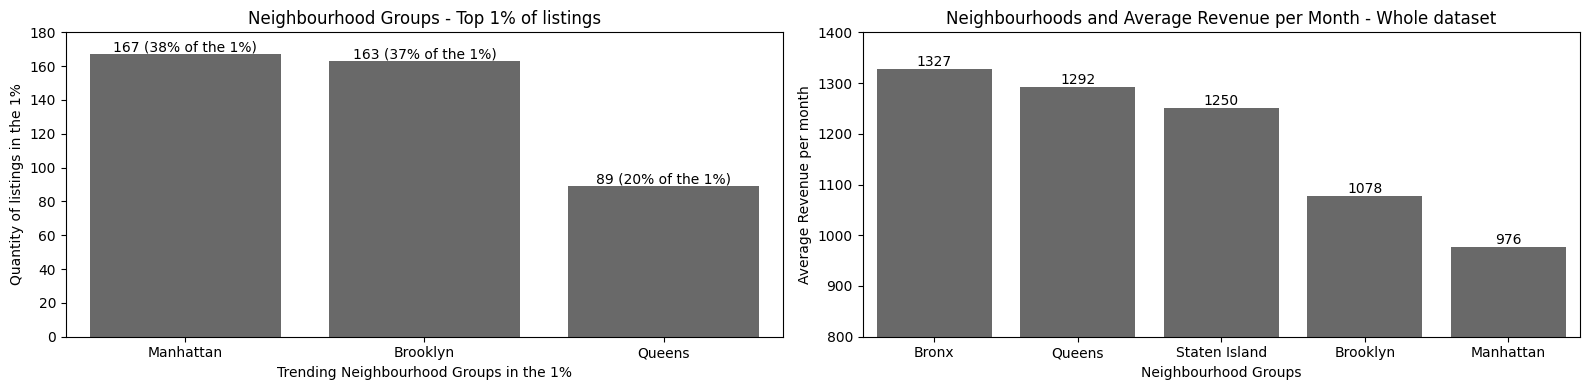

In [18]:
# Neighbourhood Groups
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4)) 

# Neighbourhood Groups - Top 1% plot
ax1 = sns.barplot(data=queries['neighbourhood_group'], x = 'neighbourhood_group', y='count', color='dimgrey', ax=ax1)
ax1.set_ylim(0, 180)
ax1.set_title("Neighbourhood Groups - Top 1% of listings")
ax1.set_xlabel('Trending Neighbourhood Groups in the 1%')
ax1.set_ylabel('Quantity of listings in the 1%')
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f'{int(x)} ({(x / (len(df)/100) * 100):.0f}% of the 1%)')

# Neighbourhood Groups - Whole dataset plot
ax2 = sns.barplot(data=sql_queries['neighbourhood_group'], x='neighbourhood_group', y='revenue_per_month', color='dimgrey', ax=ax2)
ax2.set_title("Neighbourhoods and Average Revenue per Month - Whole dataset")
ax2.set_xlabel('Neighbourhood Groups')
ax2.set_ylabel('Average Revenue per month')
ax2.set_ylim(800, 1400)
for i in ax2.containers:
    ax2.bar_label(i,)

plt.tight_layout()
plt.show()
plt.close()



The areas with the most listings in the top 1% of performers are Manhattan and Brooklyn. This indicates that these areas have the highest concentration of properties in the dataset. 

When looking at the average revenue per listing, the Bronx, Queens, and Staten Island have the highest average revenue per month. 

This could indicate that while Manhattan and Brooklyn dominate with respect to the quantity of listings, there are listings in other boroughs outperforming them by a significant amount thus increasing that boroughs average revenue per month. 

This outperformance could be dependent on the quantity of listings being considerably fewer. The weighting of these outperforming listings is much higher in the Bronx for example, than in Manhattan. 


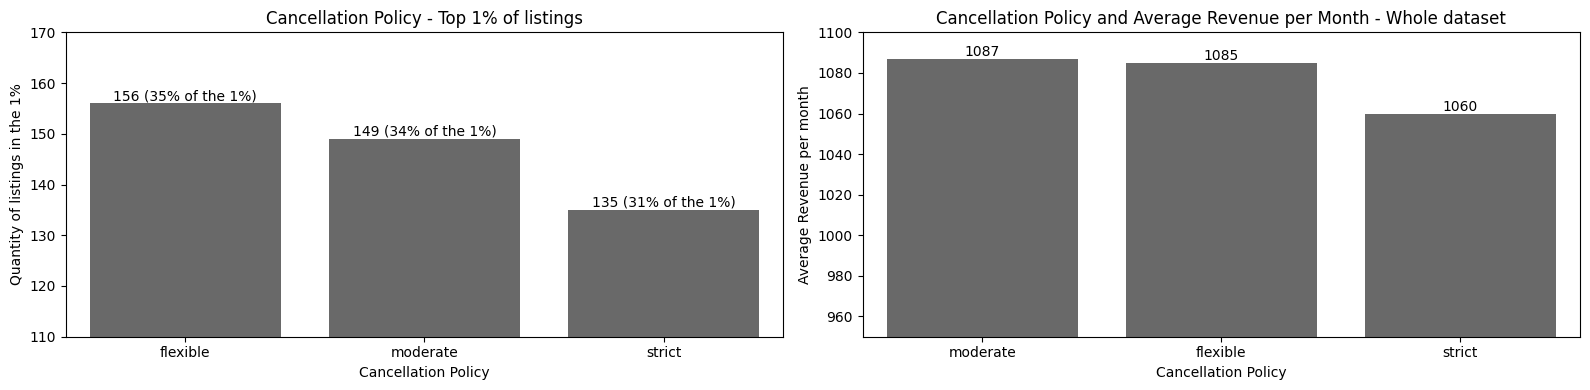

In [19]:
# Cancellation Policy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4)) 

# Cancellation Policy - Top 1% plot
ax1 = sns.barplot(data=queries['cancellation_policy'], x = 'cancellation_policy', y='count', color='dimgrey', ax=ax1)
ax1.set_title("Cancellation Policy - Top 1% of listings")
ax1.set_xlabel('Cancellation Policy')
ax1.set_ylabel('Quantity of listings in the 1%')
ax1.set_ylim(110, 170)
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f'{int(x)} ({(x / (len(df)/100) * 100):.0f}% of the 1%)')

# Cancellation Policy - Whole dataset plot
ax2 = sns.barplot(data=sql_queries['cancellation_policy'], x='cancellation_policy', y='revenue_per_month', color='dimgrey', ax=ax2)
ax2.set_title("Cancellation Policy and Average Revenue per Month - Whole dataset")
ax2.set_xlabel('Cancellation Policy')
ax2.set_ylabel('Average Revenue per month')
ax2.set_ylim(950, 1100)
for i in ax2.containers:
    ax2.bar_label(i,)

plt.tight_layout()
plt.savefig("charts/2_cancellation_policy_-_1%_vs_whole_dataset.png")
plt.close()

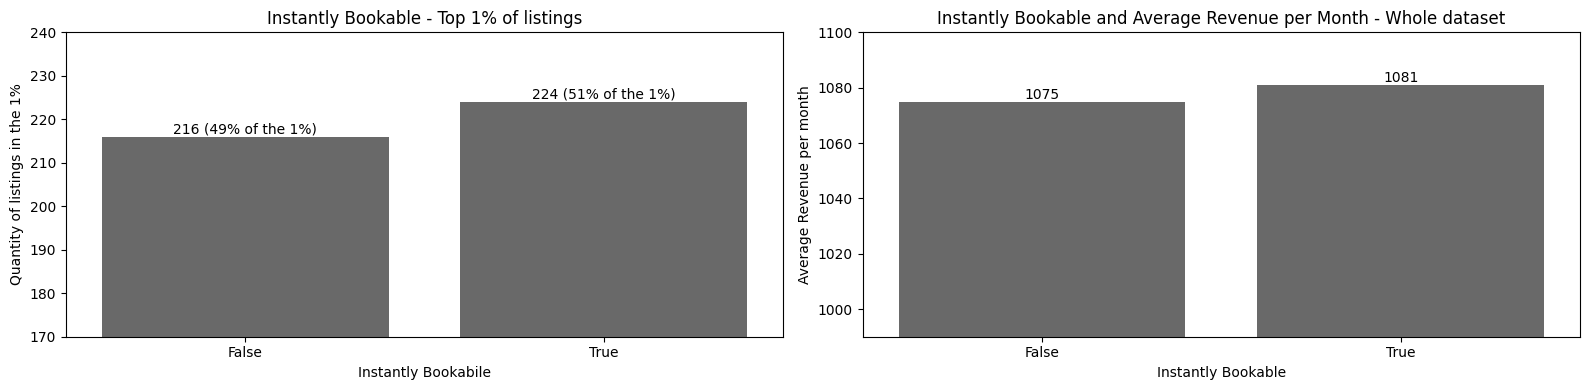

In [20]:
# Instantly Bookable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4)) 

# Instantly Bookable - Top 1% plot
ax1 = sns.barplot(data=queries['instant_bookable'], x = 'instant_bookable', y='count', color='dimgrey', ax=ax1)
ax1.set_title("Instantly Bookable - Top 1% of listings")
ax1.set_xlabel('Instantly Bookabile')
ax1.set_ylabel('Quantity of listings in the 1%')
ax1.set_ylim(170, 240)
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f'{int(x)} ({(x / (len(df)/100) * 100):.0f}% of the 1%)')

# Instantly Bookable - Whole dataset plot
ax2 = sns.barplot(data=sql_queries['instant_bookable'], x='instant_bookable', y='revenue_per_month', color='dimgrey', ax=ax2)
ax2.set_title("Instantly Bookable and Average Revenue per Month - Whole dataset")
ax2.set_xlabel('Instantly Bookable')
ax2.set_ylabel('Average Revenue per month')
ax2.set_ylim(990, 1100)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['False', 'True'])
for i in ax2.containers:
    ax2.bar_label(i,)

plt.tight_layout()
plt.show()
plt.close()

The split in the top 1% of listings is very balanced for the cancellation policy and instantly bookable data. 

This indicates that your cancellation policy or being instantly bookable doesn't affect revenue by a lot. 

This is also reflected in the average revenue per month where the difference between the options is minimal at ~2.5% for the cancellation policies and 0.5% if the listing is able to be booked instantly. 

With respect to average revenue per month, these differences favour the moderate and flexible policies and the instant bookability of the listing.

Choosing a moderate or flexible policy or allowing your property to be instantly bookable could help with other areas such as your review rating. 

If the host has multiple listings, this small difference could also provide a significant increase in income over a year. 

No information is available regarding additional costs incurred for having a moderate or flexible cancellation policy or not having an instantly bookable listing. 

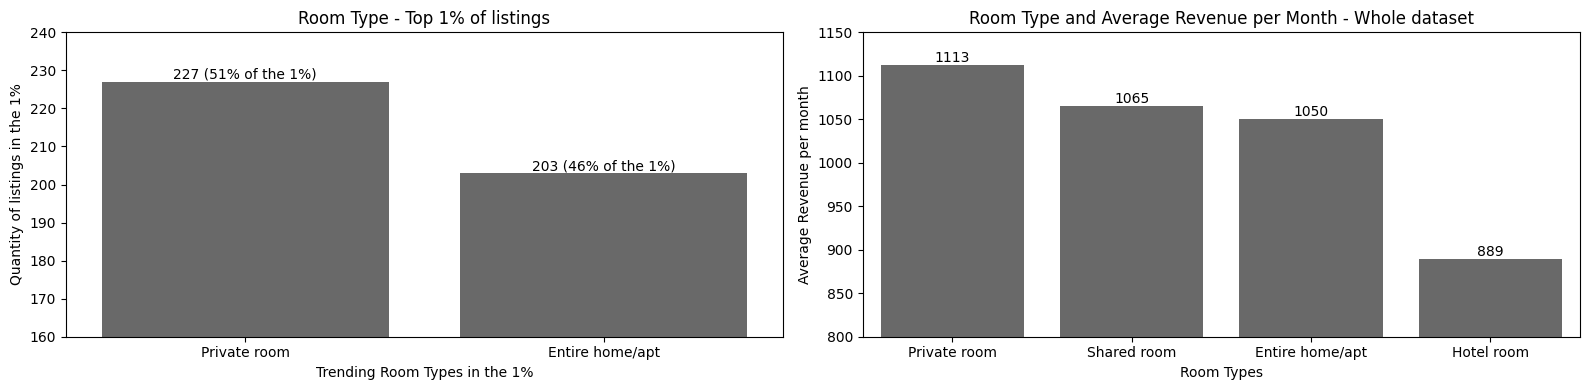

In [21]:
# Room Type
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4)) 

# Room Type - Top 1% plot
ax1 = sns.barplot(data=queries['room_type'], x = 'room_type', y='count', color='dimgrey', ax=ax1)
ax1.set_title("Room Type - Top 1% of listings")
ax1.set_xlabel('Trending Room Types in the 1%')
ax1.set_ylabel('Quantity of listings in the 1%')
ax1.set_ylim(160, 240)
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f'{int(x)} ({(x / (len(df)/100) * 100):.0f}% of the 1%)')

# Room Type - Whole dataset plot
ax2 = sns.barplot(data=sql_queries['room_type'], x='room_type', y='revenue_per_month', color='dimgrey', ax=ax2)
ax2.set_title("Room Type and Average Revenue per Month - Whole dataset")
ax2.set_xlabel('Room Types')
ax2.set_ylabel('Average Revenue per month')
ax2.set_ylim(800, 1150)
for i in ax2.containers:
    ax2.bar_label(i,)

plt.tight_layout()
plt.show()
plt.close()

Almost all room types in the top 1% of listings were an entire home/apt or a private room. 

This finding is also shared with respect to the average revenue per month, but also includes shared rooms. 

Surprisingly a Private or Shared room has a higher average monthly revenue than an entire home/apt. This could be due to the lower price points which may attract more frequent bookings. 


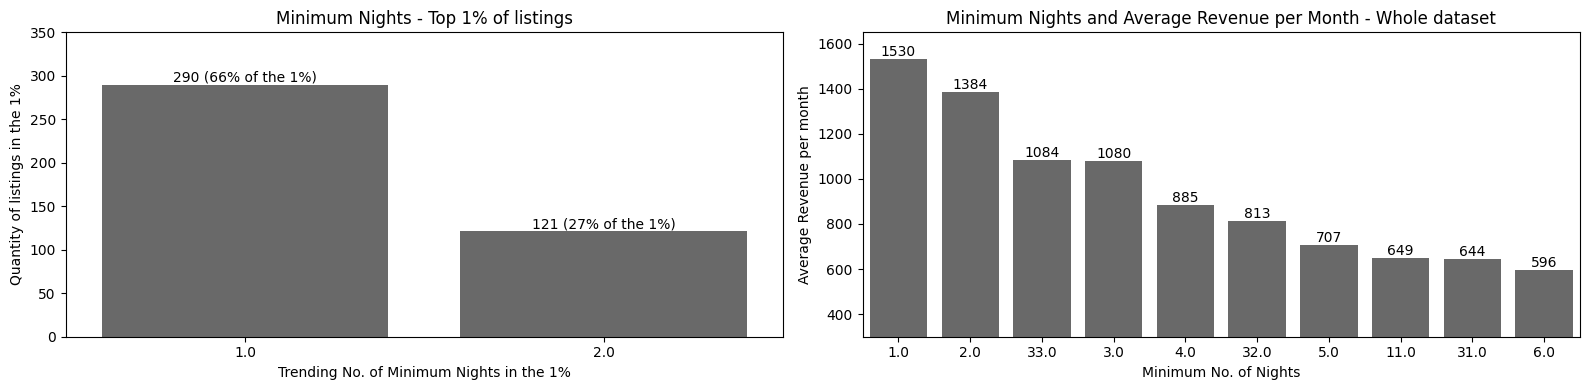

In [22]:
# Minimum Nights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4)) 

# Minimum Nights - Top 1% plot
ax1 = sns.barplot(data=queries['minimum_nights'], x = 'minimum_nights', y='count', color='dimgrey', ax=ax1)
ax1.set_title("Minimum Nights - Top 1% of listings")
ax1.set_xlabel('Trending No. of Minimum Nights in the 1%')
ax1.set_ylabel('Quantity of listings in the 1%')
ax1.set_ylim(0, 350)
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f'{int(x)} ({(x / (len(df)/100) * 100):.0f}% of the 1%)')

# Minimum Nights - Whole dataset plot
ax2 = sns.barplot(data=sql_queries['minimum_nights'], x='minimum_nights', y='revenue_per_month', color='dimgrey', order=sql_queries['minimum_nights']['minimum_nights'], ax=ax2)
ax2.set_title("Minimum Nights and Average Revenue per Month - Whole dataset")
ax2.set_xlabel('Minimum No. of Nights')
ax2.set_ylabel('Average Revenue per month')
ax2.set_ylim(300, 1650)
for i in ax2.containers:
    ax2.bar_label(i,)

plt.tight_layout()
plt.show()
plt.close()


Most listings in the top 1% of performers allow for a minimum of 1 or 2 nights. 1 night taking the lead at 66% of the 1%. 

This is consistent with the findings found with respect to the average revenue per month, though surprisingly a minimum of 33 nights was ranked third.

Though surprising, this data doesn't take into account how many properties allow for a minimum of 33 nights. It's assumed that few properties allow for a minimum of 33 nights, and higher returns on some of these listings would have a larger weighting on the overall average monthly revenue. 

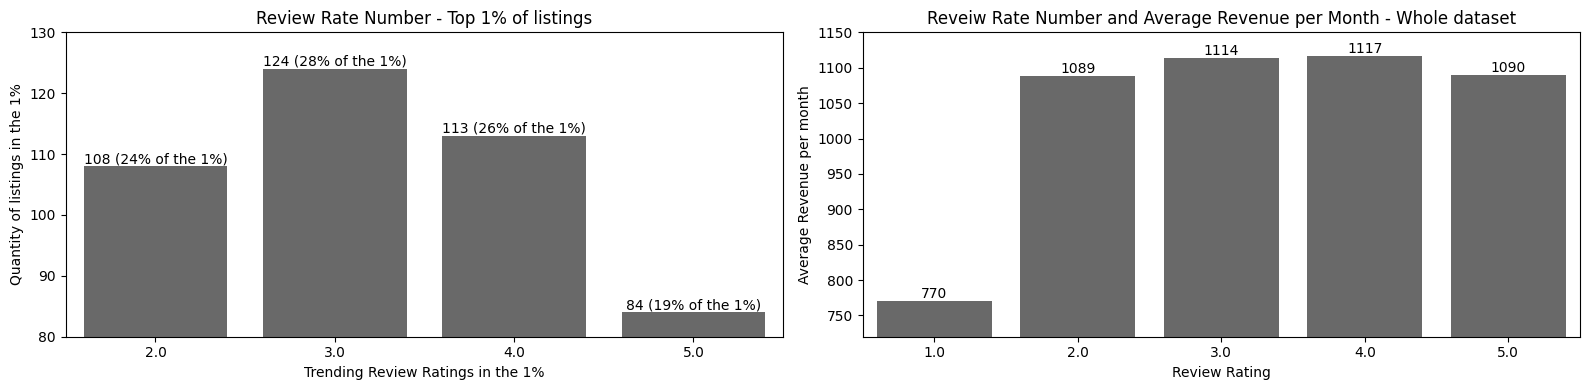

In [23]:
# Review Rate Number
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4)) 

# Review Rate Number - Top 1% plot
ax1 = sns.barplot(data=queries['review_rate_number'], x ='review_rate_number', y='count', color='dimgrey', ax=ax1)
ax1.set_title("Review Rate Number - Top 1% of listings")
ax1.set_xlabel('Trending Review Ratings in the 1%')
ax1.set_ylabel('Quantity of listings in the 1%')
ax1.set_ylim(80, 130)
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f'{int(x)} ({(x / (len(df)/100) * 100):.0f}% of the 1%)')

# Review Rate Number - Whole dataset plot
ax2 = sns.barplot(data=sql_queries['review_rate_number'], x='review_rate_number', y='revenue_per_month', color='dimgrey', ax=ax2)
ax2.set_title("Reveiw Rate Number and Average Revenue per Month - Whole dataset")
ax2.set_xlabel('Review Rating')
ax2.set_ylabel('Average Revenue per month')
ax2.set_ylim(720, 1150)
for i in ax2.containers:
    ax2.bar_label(i,)

plt.tight_layout()
plt.show()
plt.close()

Ratings of 2, 3, and 4 were very balanced within the top 1% of performers whilst a rating of 5 was less prevelant but still notable at 19% of the total listings within the top 1%. 

This finding stays pretty consistent with respect to the Average revenue per month. The differences in revenue between a rating of 2, 3, 4 and 5 is approximately 2.5%. 

The average revenue of a rating of 1 is considerably lower and should be avoided at all costs.





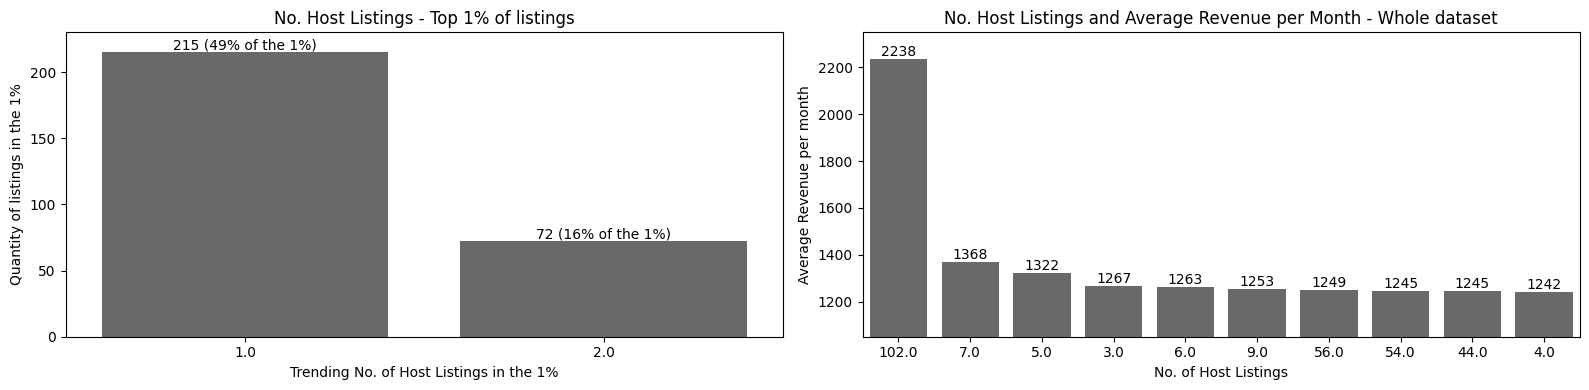

In [24]:
# No. of Listings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4)) 

# No. of Listings - Top 1% plot
ax1 = sns.barplot(data=queries['calculated_host_listings_count'], x = 'calculated_host_listings_count', y='count', color='dimgrey', ax=ax1)
ax1.set_title("No. Host Listings - Top 1% of listings")
ax1.set_xlabel('Trending No. of Host Listings in the 1%')
ax1.set_ylabel('Quantity of listings in the 1%')
ax1.set_ylim(0, 230)
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f'{int(x)} ({(x / (len(df)/100) * 100):.0f}% of the 1%)')

# No. of Listings - Whole dataset plot
ax2 = sns.barplot(data=sql_queries['calculated_host_listings_count'], x='calculated_host_listings_count', y='revenue_per_month', color='dimgrey', order=sql_queries['calculated_host_listings_count']['calculated_host_listings_count'], ax=ax2)
ax2.set_title("No. Host Listings and Average Revenue per Month - Whole dataset")
ax2.set_xlabel('No. of Host Listings')
ax2.set_ylabel('Average Revenue per month')
ax2.set_ylim(1050, 2350)
for i in ax2.containers:
    ax2.bar_label(i,)

plt.tight_layout()
plt.show()
plt.close()

conn.close()

Most top performing listings belonged to hosts with only one or two properties, suggesting that small-scale hosts can still compete at a high level.

The number of host listings is quite varied when looking at the whole dataset, it indicates that the number of properties owned doesn't impact revenue on each listing. 


# Insights

A private or shared room, in the Bronx or Queens would be best when listing your property. 

The cancellation policy and being able to book the listing instantly doesn't seem to have a direct relation to revenue per month. 

The optimal minimum number of nights is 1 or 2. 

A rating of 3 or 4 is optimal. Having a rating of 1 negatively impacts revenue. A rating of 5 shows less revenue than a rating of 4 indicating diminishing returns. 

The number of properties owned by the host doesn't impact the average revenue for a specific listing. 


# Conclusions

There are a few glaring issues with my analysis, the main three that i've identified are as follows.

# .
The analysis of the top 1% of performing listings seems to relate more with how popular an aspect of a listing is rather than if it results in more revenue. 

This could potentially be solved by analysing the top 0.1% of the top performing listings, though this will likely come with it's own set of problems. 
# .
Another issue is the fact that the weighting of the results wasn't considered. A few high performing listings can skew the results significantly.  

Though this type of data was ultimately what i was looking for; i was looking for similarities in the few, very high performing listings, it could be argued that it's been done in an ambiguous way. 

A solution could be to show the count alongside each average or even filtering out low-count groups for specific queries. 
# .
Another issue affecting the whole dataset is the fact that the profit wasn't considered which provides limited analysis on some of the datapoints like the cancellation policy, quantity of listings per host and instant bookability.  

I don't see a solution to this with the data available, however revenue is still a realiable measure when analysing a business. 


